In [1]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.ops.maap-project.org')

# Launch DPS for 3.1.2_dps.py
multi-spectral composites


In [2]:
from os import path
import os, glob
import datetime
import pandas as pd
import geopandas as gpd
!pip install xmltodict
import xmltodict

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


  Using cached xmltodict-0.12.0-py2.py3-none-any.whl (9.2 kB)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Show status of MS composites for boreal tiles: find tiles still NEEDED
    Colored tiles indicate those still needed - water tiles removed
    BLACK tiles are processed

In [463]:
def GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS',
                    boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg',
                    GROUP_FIELD = 'tile_group',
                    tindex_master_fn = 's3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/HLS_tindex_master.csv',
                    topo_tindex_master_fn = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv',
                    bad_tiles = [3540,3634,3728,3823,3916,4004], #Dropping the tiles near antimeridian that reproject poorly.
                    REMOVE_BAD_TILES = False
                   ):

    # Get all boreal tiles
    #shared-buckets/nathanmthomas/boreal_grid_albers90k_gpkg.gpkg
    boreal_tile_index = gpd.read_file(boreal_tile_index_path)
    
    if REMOVE_BAD_TILES:
        # Remove bad tiles
        boreal_tile_index = boreal_tile_index[~boreal_tile_index['tile_num'].isin(bad_tiles)]

    print(boreal_tile_index.groupby(GROUP_FIELD)[GROUP_FIELD].agg(['count']))
    
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize'] = [16, 16]

    hls_tindex_master = pd.read_csv(tindex_master_fn)
    topo_tindex_master = pd.read_csv(topo_tindex_master_fn)

    hls_tindex = boreal_tile_index.merge(hls_tindex_master[['tile_num','s3_path','local_path']], how='right', on='tile_num')
    topo_tindex = boreal_tile_index.merge(topo_tindex_master[['tile_num','s3_path','local_path']], how='right', on='tile_num')

    print(f"Tile status report for {DPS_DATA_TYPE} from {tindex_master_fn}:")
    print(f'\t# of boreal tiles in boreal v003:\t\t\t{len(boreal_tile_index)}')

    # Get water tiles
    water_tiles = list(set(boreal_tile_index.tile_num) - set(topo_tindex.tile_num) )
    print(f'\t# of boreal tiles in water:\t\t\t\t{len(water_tiles)}')

    NUM_STUDY_TILES = len(boreal_tile_index[~boreal_tile_index['tile_num'].isin(water_tiles)])
    print(f'\t# of boreal tiles used study (from Topo coverage):\t{NUM_STUDY_TILES}')

    ax = boreal_tile_index[~boreal_tile_index['tile_num'].isin(water_tiles)].plot(column=GROUP_FIELD, legend=True)
    #ax = tiles_topo_index.plot(color='gray', ax=ax)
    ax = hls_tindex.plot(color='black', ax = ax)
    print(f'\t# of boreal tiles with {DPS_DATA_TYPE}:\t\t\t\t{len(hls_tindex)}')

    needed_tindex = boreal_tile_index[~boreal_tile_index['tile_num'].isin(hls_tindex.tile_num.to_list() + water_tiles)]
    LIST_TILES_NEEDED = needed_tindex.tile_num.to_list()
    print(f'\t# of boreal tiles still needing {DPS_DATA_TYPE}:\t\t\t{len(LIST_TILES_NEEDED)}')
    needed_tindex.iloc[0:100].plot(color='#525252', ax = ax)
    return LIST_TILES_NEEDED


                      count
tile_group                 
alaska extra             20
canada extra             49
conus extra              25
eurasia central        1169
eurasia east           1098
eurasia north           159
eurasia west            612
europe north            290
fennoscand south         26
north america centra    714
north america east      494
north america west      470
uk                       70
Tile status report for HLS from s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/HLS_tindex_master.csv:
	# of boreal tiles in boreal v003:			5196
	# of boreal tiles in water:				124
	# of boreal tiles used study (from Topo coverage):	5072
	# of boreal tiles with HLS:				1412
	# of boreal tiles still needing HLS:			3661


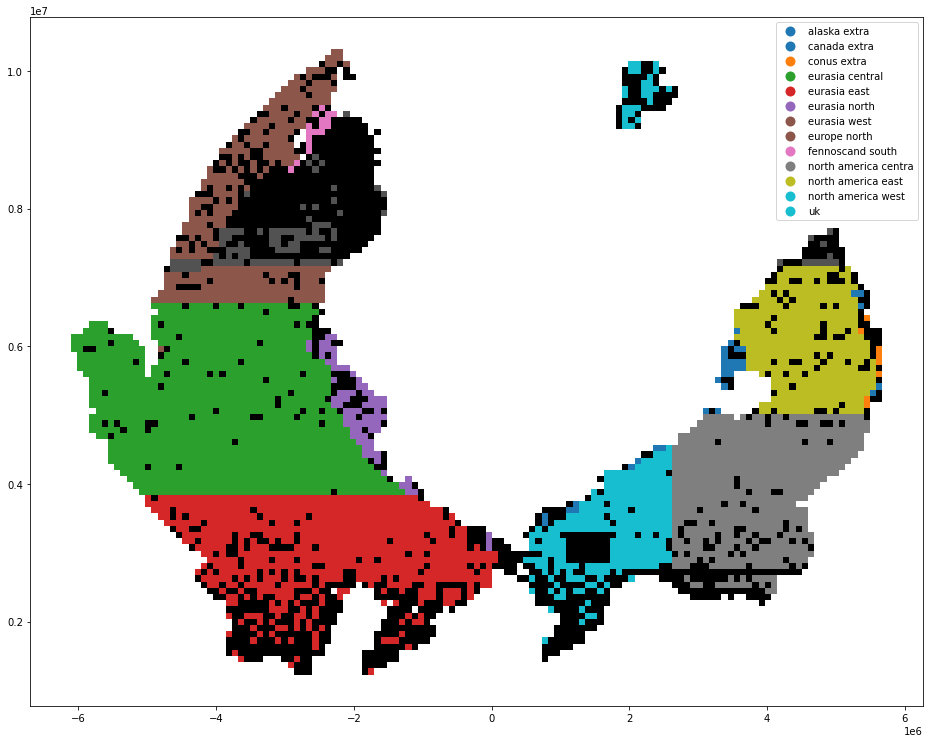

In [478]:
HLS_TILES_NEEDED = GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS')

In [479]:
INPUT_TILE_NUM_LIST = HLS_TILES_NEEDED
len(INPUT_TILE_NUM_LIST)


3661

In [466]:
DO_EXPERIMENT = False

In [467]:
if DO_EXPERIMENT:
    
    NORWAY_TILE_LIST = pd.read_csv('/projects/shared-buckets/lduncanson/misc_files/norway_tiles.csv').layer.tolist()

    DELTA_TILE_LIST = [3365,3366,3367,3458,3459,3460,3353,3354,3355] + [3361, 3362]
    BONA_TILE_LIST  = [3270,3271,3272, 3456,3457,  3363,3364,3365] + [3268, 3269]
    HEALY_TILE_LIST = [ 3551,3552,3553,3645,3646,3647] + [3648, 3649, 3555, 3554]

    #DELTA_TILE_LIST = [3365,3366,3367,3458,3460,3353,3354,3355,3549]
    #BONA_TILE_LIST  = [3270,3271,3272,3364,3456,3457,3458,3364,3365]
    #HEALY_TILE_LIST = [3456,3457,3458,3551,3552, 3553,3645,3646,3647]
    INPUT_EXPERIMENT_TILE_NUM_LIST = NORWAY_TILE_LIST + DELTA_TILE_LIST + BONA_TILE_LIST + HEALY_TILE_LIST
    ALASKA_TILE_LIST =  list(range(3268,3272+1))+\
                        list(range(3361,3366+1))+\
                        list(range(3454,3459+1))+\
                        list(range(3549,3555+1))+\
                        list(range(3643,3648+1))

    INPUT_EXPERIMENT_TILE_NUM_LIST = NORWAY_TILE_LIST + ALASKA_TILE_LIST
    len(INPUT_EXPERIMENT_TILE_NUM_LIST)

In [468]:
if DO_EXPERIMENT:
    
    ILAB_AK_TILE = [3000]
    KENAI_TILE = [4017]
    ARY_MAS_TILE = [37744, 37743, 37742]
    NRWY_TILE = [131]
    SESIB_TILE = [3421]
    HOWLAND_TILE = [34210]
    BC_TILES = list(range(3846,3868+1)) 
    MISC_TILES = ARY_MAS_TILE + ILAB_AK_TILE + KENAI_TILE + HOWLAND_TILE + BC_TILES + SESIB_TILE# + NRWY_TILE
    print(len(MISC_TILES))
    
    print(len(MISC_TILES + INPUT_EXPERIMENT_TILE_NUM_LIST))
    
    DPS_INPUT_TILE_NUM_LIST = HOWLAND_TILE + ARY_MAS_TILE
    print(len(DPS_INPUT_TILE_NUM_LIST))
    

In [480]:
TEST_DPS  = False

if TEST_DPS:
    print('Running DPS on a SUBSET list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST[-10:]
else:
    if DO_EXPERIMENT:
        print('Running DPS on the FULL list of EXPERIMENT input')
        DPS_INPUT_TILE_NUM_LIST = MISC_TILES + INPUT_EXPERIMENT_TILE_NUM_LIST
    else:
        print('Running DPS on the FULL list of input')
        DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST
    
print(f"List length: {len(DPS_INPUT_TILE_NUM_LIST)}")

Running DPS on the FULL list of input
List length: 3661


# Run a DPS of MS Composite tiles

In [481]:
DPS_INPUT_TILE_NUM_LIST = DPS_INPUT_TILE_NUM_LIST[2000:2100]
MAX_CLOUDS = 25
RUN_NAME = f'mc{MAX_CLOUDS}_3yrs'
RUN_NAME

'mc25_3yrs'

In [482]:
%%time
submit_results_df_list = []
len_input_list = len(DPS_INPUT_TILE_NUM_LIST)
print(f"# of input tiles for DPS: {len_input_list}")

for i, INPUT_TILE_NUM in enumerate(DPS_INPUT_TILE_NUM_LIST):

    DPS_num = i+1
    IDENTIFIER = "do_HLS_stack_3-1-2"
    ALGO_ID = f'{IDENTIFIER}_ubuntu'
    USER = 'nathanmthomas'
    WORKER_TYPE = 'maap-dps-worker-32gb'
    
    in_param_dict = {
                         'in_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_tiles_v003.gpkg',
                         'in_tile_num': INPUT_TILE_NUM,
                         'in_tile_layer': 'boreal_tiles_v003',
                         'sat_api': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD',
                        #'sat_api': 'https://landsatlook.usgs.gov/sat-api',
                         'tile_buffer_m': 0,
                         'start_year': '2019',
                         'end_year': '2021',
                         'start_month_day': '06-01',
                         'end_month_day': '09-15',
                         'max_cloud': MAX_CLOUDS,
                         'composite_type': 'HLS'
        }
        
    submit_result = maap.submitJob(
                                    identifier=IDENTIFIER,
                                    algo_id=ALGO_ID,
                                    version="master",
                                    username=USER,
                                    queue=WORKER_TYPE,
                                    # Args that match yaml
                                    **in_param_dict
        )
    
    # Build a dataframe of submission details
    submit_result['dps_num'] = DPS_num
    submit_result['tile_num'] = INPUT_TILE_NUM
    submit_result['submit_time'] = datetime.datetime.now()
    submit_result['dbs_job_hour'] =datetime.datetime.now().hour
    submit_result['algo_id'] = ALGO_ID
    submit_result['user'] = USER
    submit_result['worker_type'] = WORKER_TYPE
    
    # Append to a list of data frames of submission results
    submit_results_df_list.append(pd.DataFrame([submit_result]))
    
    if DPS_num in [1, 25,50, 100,200,300,400,500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 21000, 24000, len_input_list]:
        print(f"DPS run #: {DPS_num}\t| tile num: {INPUT_TILE_NUM}\t| submit status: {submit_result['status']}\t| job id: {submit_result['job_id']}") 
        
# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
submit_results_df['run_name'] = RUN_NAME
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/DPS_{IDENTIFIER}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df

# of input tiles for DPS: 100
DPS run #: 1	| tile num: 2558	| submit status: success	| job id: f0ae47ff-4802-4527-a97b-09bbd5880d6b
DPS run #: 25	| tile num: 2582	| submit status: success	| job id: 96e95db9-7554-4bd9-80c8-0f47258e15fc
DPS run #: 50	| tile num: 2610	| submit status: success	| job id: 89dfddca-3403-4a5e-b44b-77f138a12d20
DPS run #: 100	| tile num: 2661	| submit status: success	| job id: d906591f-3ba4-4bf2-83fd-c5a63133bf6f
Current time:	202203291226
CPU times: user 1.2 s, sys: 64.9 ms, total: 1.27 s
Wall time: 23.3 s


,status,http_status_code,job_id,dps_num,tile_num,submit_time,dbs_job_hour,algo_id,user,worker_type,run_name
0,success,200,f0ae47ff-4802-4527-a97b-09bbd5880d6b,1,2558,2022-03-29 12:26:20.626262,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_3yrs
0,success,200,54264fed-91ef-4e22-a253-1c8e0aeb5849,2,2559,2022-03-29 12:26:20.724152,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_3yrs
0,success,200,c65732a5-6847-4caf-bfc4-99c0811d2c19,3,2560,2022-03-29 12:26:20.843499,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_3yrs
0,success,200,55ee5189-8873-420b-9fb1-9fee79aa9789,4,2561,2022-03-29 12:26:21.002684,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_3yrs
0,success,200,0151261d-5891-4c58-9582-2d7bd3edde90,5,2562,2022-03-29 12:26:21.231130,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_3yrs
...,...,...,...,...,...,...,...,...,...,...,...
0,success,200,6a8891a8-1ae3-4e38-a9a8-605fef87a70e,96,2657,2022-03-29 12:26:42.619509,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_3yrs
0,success,200,df5ef7b8-74cc-494c-a8b4-b36cb57dc349,97,2658,2022-03-29 12:26:42.821023,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_3yrs
0,success,200,2e3892b6-8488-4155-ba71-3596fd2b0b51,98,2659,2022-03-29 12:26:43.070471,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_3yrs
0,success,200,56f86493-0d14-44e6-a9c3-1715219e1856,99,2660,2022-03-29 12:26:43.311609,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_3yrs


After almost any DPS job, you have to assess what succeeded and failed. This involves:
1. building a table of job status based on job ids captured in the job_results_df from the DPS run chunk (this takes 40 mins for ~47k jobs) --> this tells you how many jobs failed
2. merging the job status table with the job results df --> this tells you which specific granules (or tile nums) failed
3. building another input list of granules for a follow-up DPS
## Assess DPS results
Build a table of job status based on job id - how many jobs failed?

In [252]:
def BUILD_TABLE_JOBSTATUS(submit_results_df):
    import xmltodict
    job_status_df = pd.concat([pd.DataFrame(xmltodict.parse(maap.getJobStatus(job_id).content)).transpose() for job_id in submit_results_df.job_id.to_list()])
    job_status_df = submit_results_df.merge(job_status_df, how='left', left_on='job_id',  right_on='wps:JobID')
    return job_status_df

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 13.4 µs


In [477]:
%%time
z = BUILD_TABLE_JOBSTATUS(submit_results_df)

print(f'Count total jobs:\t{len(z)}')
print(f"Count pending jobs:\t{z[z['wps:Status'] =='Accepted'].shape[0]}")
print(f"Count running jobs:\t{z[z['wps:Status'] =='Running'].shape[0]}")
print(f"Count succeeded jobs:\t{z[z['wps:Status'] =='Succeeded'].shape[0]}")
print(f"Count failed jobs:\t{z[z['wps:Status'] =='Failed'].shape[0]}")
print(f"% of failed jobs:\t{round(z[z['wps:Status'] =='Failed'].shape[0] / ( z[z['wps:Status'] =='Failed'].shape[0] + z[z['wps:Status'] =='Succeeded'].shape[0] ), 4) * 100}")

Count total jobs:	100
Count pending jobs:	0
Count running jobs:	7
Count succeeded jobs:	47
Count failed jobs:	46
% of failed jobs:	49.46
CPU times: user 1.18 s, sys: 70 ms, total: 1.25 s
Wall time: 3.21 s


In [455]:
print(z[z['wps:Status'] =='Succeeded'].tile_num.to_list())

[]


### Get a list of the FAILS to run through DPS again

In [445]:
DPS_INPUT_TILE_NUM_LIST = z[z['wps:Status'] =='Failed'].tile_num.to_list()#[0:75]
print(DPS_INPUT_TILE_NUM_LIST)

[1, 56, 68, 70, 86, 118, 122, 125, 129, 140, 142, 149, 155, 156, 157, 159, 161, 162, 164, 165, 166, 169, 170, 179, 184, 185, 189, 194, 208, 209, 212, 213, 215, 218, 237, 238, 239, 240, 241, 242, 243, 244, 245, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 277, 278, 279, 280, 281, 282, 283, 285, 286, 287, 288, 289, 290]


In [ ]:
z[z['wps:Status'] =='Failed']

In [436]:
xmltodict.parse(maap.getJobResult(z[z['wps:Status'] =='Failed'].iloc[300].job_id).content)

OrderedDict([('wps:Result',
              OrderedDict([('@xmlns:ows', 'http://www.opengis.net/ows/2.0'),
                           ('@xmlns:schemaLocation',
                            'http://schemas.opengis.net/wps/2.0/wps.xsd'),
                           ('@xmlns:wps', 'http://www.opengis.net/wps/2.0'),
                           ('@xmlns:xsi',
                            'http://www.w3.org/2001/XMLSchema-instance'),
                           ('wps:JobID',
                            'c928b149-77b3-4ca8-98f8-f448c02a83ec'),
                           ('wps:Output',
                            OrderedDict([('@id', 'traceback'),
                                         ('wps:Data',
                                          'activate does not accept more than one argument:\n[\'/app/icesat2_boreal/dps/alg_3-1-2/run.sh\', \'1766\', \'boreal_tiles_v003\', \'https://cmr.earthdata.nasa.gov/stac/LPCLOUD\', \'0\', \'2019\', \'2021\', \'06-01\', \'09-15\', \'25\', \'HLS\']\n\n+ /app/icesat2

In [ ]:
#!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt

In [ ]:
#!python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t HLS -y 2022 -m 03 -d_min 23